# 

# DIVAnd : Surface currents computation through variational inverse method
### A study case on the Mediterranean Sea

### Used dataset :
###### INSITU_GLO_PHY_UV_DISCRETE_MY_013_044 (HFRadars and drifters)
###### SEALEVEL_EUR_PHY_L3_MY_008_061 (Sea Level, bundle of satellites)

In [1]:
using Pkg;
Pkg.instantiate();

In [49]:
##################### lIBRARIES #########################

cd("/home/jovyan/CoastalCurrents/examples/")

using CoastalCurrents
using CoastalCurrents: Altimetry
using CoastalCurrents: HFRadar
using DIVAnd_HFRadar
using PhysOcean
using GeoMapping
using Plots
using PyPlot
using NCDatasets
using Dates
using Test
using DIVAnd
using DataStructures
using Statistics
using Glob
#using Pkg
#Pkg.add("Interpolations")
using Interpolations

include("common.jl")
include("parm_to_RMS.jl")
include("DATA_PREPARATION.jl")

DataPreparation (generic function with 1 method)

In [50]:
# usefull macro to shut down outputs of the functions
# add '@silent' in front of functions to be silenced out

macro silent(expr)
    return quote
        open("/dev/null", "w") do devnull
            redirect_stdout(devnull) do
                redirect_stderr(devnull) do
                    $(esc(expr))  # Évalue l'expression sans afficher les sorties
                end
            end
        end
    end
end

@silent (macro with 1 method)

In [51]:
################## DIRECTORIES FOR SAVING FIG ######################


save_results = "/home/jovyan/CoastalCurrents.jl/examples/resultats_finaux/"
save_validation = "/home/jovyan/CoastalCurrents.jl/examples/resulatst_validation/"
save_broll = "/home/jovyan/CoastalCurrents.jl/examples/Results//"

"/home/jovyan/CoastalCurrents.jl/examples/Results//"



# Drifter's data loading



In [52]:
# Loading of the drifter's variables

londo,latdo,timedo,udo,vdo = CoastalCurrents.loaddata("/home/jovyan/tmp/BlueCloud2026/Drifter/my.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_MY_013_044/cmems_obs-ins_glo_phy-cur_my_drifter_PT6H/history/Dr1.nc"); 

# Creation of drifter ID variable

ds_id = NCDataset("/home/jovyan/tmp/BlueCloud2026/Drifter/my.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_MY_013_044/cmems_obs-ins_glo_phy-cur_my_drifter_PT6H/history/Dr1.nc")
drifter_id = ds_id["DRIFTER_ID"][:];
close(ds_id)


fname = "/home/jovyan/tmp/BlueCloud2026/Drifter/my.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_MY_013_044/cmems_obs-ins_glo_phy-cur_my_drifter_PT6H/history/Dr1.nc"
length(lon) = 465701
length(lat) = 465701


closed Dataset

#### Selection of the considered region

In [6]:
# Taking the corresponing longitude and latitude

indices_a_supprimer_long = findall(x -> !(x >= -5 && x <= 35.5), londo);
#indices_a_supprimer_long = findall(x -> !(x >= lonmin && x <= lonmax), londo);    Marche pas car taille du dataset idvalid est pas bon


deleteat!(londo, indices_a_supprimer_long);
deleteat!(latdo, indices_a_supprimer_long);
deleteat!(timedo, indices_a_supprimer_long);
deleteat!(udo, indices_a_supprimer_long);
deleteat!(vdo, indices_a_supprimer_long);
deleteat!(drifter_id, indices_a_supprimer_long);

indices_a_supprimer_lat = findall(y -> !(y >= 30 && y <= 45), latdo);
#indices_a_supprimer_lat = findall(y -> !(y >= latmin && y <= latmax), latdo);     Marche pas car taille du dataset idvalid est pas bon


deleteat!(londo, indices_a_supprimer_lat)
deleteat!(latdo, indices_a_supprimer_lat);
deleteat!(timedo, indices_a_supprimer_lat);
deleteat!(udo, indices_a_supprimer_lat);
deleteat!(vdo, indices_a_supprimer_lat);
deleteat!(drifter_id, indices_a_supprimer_lat);

#### Spatial and temporal repartition of drifters

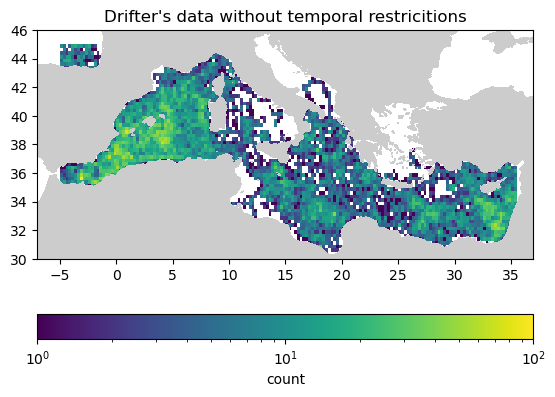

In [7]:
# Plot of the data to better see the repartition

plt.hist2d(londo,latdo,(lonr,latr),norm=matplotlib.colors.LogNorm())
colorbar(orientation="horizontal",label="count")
CoastalCurrents.Plotting.plotmap(bathname)
title("Drifter's data without temporal restricitions");

#PyPlot.savefig(joinpath(save_results, "drifter_spacecoverage_allT.png"))

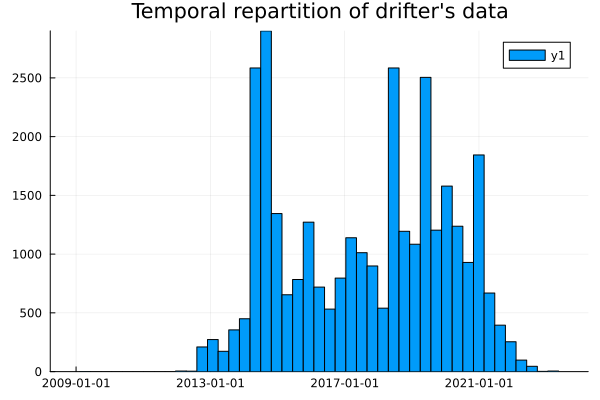

In [8]:
# Temporal repartition of the drifter's data

p1 = histogram(udo,timedo,lw = 1)
title!("Temporal repartition of drifter's data")
#Plots.savefig(joinpath(save_results, "drifter_timecoverage.png"))



### Creating the validation subset (10% of the drifter dataset)



##### Pour l'automatisation, créer un dataset de la taille adéquate pour découper les drifters en 10%-90%

In [9]:
# Creation of dsValid
# Repeated cell in data_prep

dsValid = NCDataset("/home/jovyan/CoastalCurrents/examples/ValidIndices.nc")

for_cv = dsValid["for_cv"][:] 

close(dsValid)

for_cvR = round.(Int, for_cv);

# Separation through indices of "for_cvR"

udov = udo[for_cvR .== 1];
vdov = vdo[for_cvR .== 1];
londov = londo[for_cvR .== 1];
latdov = latdo[for_cvR .== 1];
timedov = timedo[for_cvR .== 1];

# Retrieving NaNs

londov_ = londov[.!isnan.(udov)];
latdov_ = latdov[.!isnan.(udov)];
timedov_ = timedov[.!isnan.(udov)];
udov_ = udov[.!isnan.(udov)];
vdov_ = vdov[.!isnan.(udov)];

### Spatial and temporal repartition of the validation subset

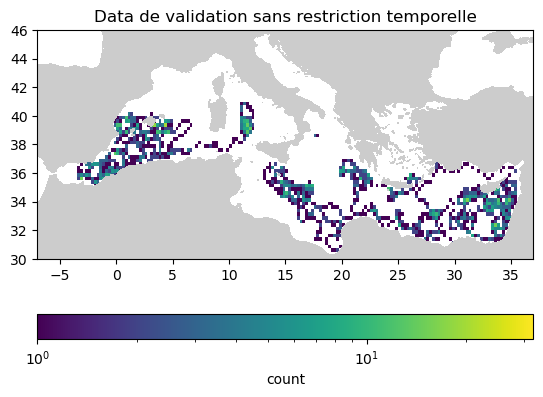

In [10]:
plt.hist2d(londov_,latdov_,(lonr,latr),norm=matplotlib.colors.LogNorm())
colorbar(orientation="horizontal",label="count")
CoastalCurrents.Plotting.plotmap(bathname)
title("Data de validation sans restriction temporelle");

#PyPlot.savefig(joinpath(save_validation, "drifter_spacecoverage_allT.png"))

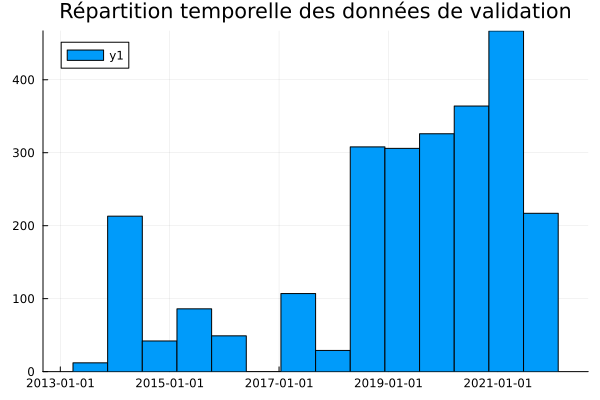

In [11]:
p1 = histogram(udov_,timedov_,lw = 1)
title!("Répartition temporelle des données de validation")



# Pre-treatment of the dataset



In [12]:
# Data preparation
# Selection of the considered year

year = 2020
#robsa_,ya_,xa_,directionobsa_,robs_HF1,directionobs_HF1,x_HF1,y_HF1,robsd_,yd_,xd_,directionobsd_ = DataPreparation(year); 

robsa_,ya_,xa_,directionobsa_,robs_HF1,directionobs_HF1,x_HF1,y_HF1,robsd_,yd_,xd_,directionobsd_,ua_vec,va_vec,ud_vec,vd_vec,ur_vec,vr_vec,u_geo,v_geo = DataPreparation(year); 



fname = "/home/jovyan/tmp/BlueCloud2026/Drifter/my.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_MY_013_044/cmems_obs-ins_glo_phy-cur_my_drifter_PT6H/history/Dr1.nc"
length(lon) = 465701
length(lat) = 465701


In [65]:

filesHFRadar = String[]; 
for (root, dirs, files2) in walkdir(hf_dir); #le directory précisé dans le common.jl dans examples
    for file in files2
        push!(filesHFRadar,joinpath(root, file)); # add path to files (names in the string)
    end
end


# Define the mask and necessary variables for interpolation


In [13]:
# Mask loading
# bathname & bathisgoal are defined in common.jl

mask,(pm,pn),(xi,yi) = DIVAnd.domain(bathname,bathisglobal,lonr,latr)
mask = DIVAnd.floodfill(mask) .== 1
hx, hy, h = DIVAnd.load_bath(bathname, bathisglobal, lonr, latr);


# Trick of sea removing to avoid mistakes 
mask[:,end] .= 0;
mask[:,end-1] .= 0;



# Variable definition for the interpolation
n = 12  # Longueur du vecteur

# Error variance of the observations
epsilon2_alt = Vector{Vector{Float64}}(undef, n);
epsilon2_drift = Vector{Vector{Float64}}(undef, n);
epsilon2_HF = Vector{Vector{Float64}}(undef, n);
epsilon2 = Vector{Vector{Float64}}(undef, n);
speedi = Vector{Vector{Float64}}(undef, n);

# Interpolated velocities and surface elevation
uri = zeros(Float64, size(h)[1], size(h)[2], n)
vri = zeros(Float64, size(h)[1], size(h)[2], n)
ηi = zeros(Float64, size(h)[1], size(h)[2], n)

# Positions and velocity (value and direction)
x_tot = Vector{Vector{Float64}}(undef, n);
y_tot = Vector{Vector{Float64}}(undef, n);
robs_tot = Vector{Vector{Float64}}(undef, n);
directionobs_tot = Vector{Vector{Float64}}(undef, n);

# Variational inverse method function: Parametrization to the Validation scheme

#### Goes from parameters to RMS error
#### Starting with parameters and year of the validation
#### Can be used as a cost function to optimize parameters

In [14]:
# Parameter selection

Cor_len = 137803.47;
Epsilon2Alt = 0.02562;
Epsilon2Drift = 0.00618;
Epsilon2HFR = 0.098563;

In [15]:
# Parameters are put in x

x = (Cor_len, Epsilon2Alt, Epsilon2Drift, Epsilon2HFR)

vecteurUisansNaN,vecteurVisansNaN,vecteurUOBSsansNaN,vecteurVOBSsansNaN,udov1_,vdov1_,reinterpole_uri,reinterpole_vri,xo1_,yo1_,speedo,speedi_,xval,yval = cosfunction(x, year); 

1 st month computed
2 th month computed
3 th month computed
4 th month computed
5 th month computed
6 th month computed
7 th month computed
8 th month computed
9 th month computed
10 th month computed
11 th month computed
12 th month computed

reinterpolation done

parameters are : (137803.47, 0.02562, 0.00618, 0.098563)^[1] ,(137803.47, 0.02562, 0.00618, 0.098563)^[2] ,(137803.47, 0.02562, 0.00618, 0.098563)^[3] ,(137803.47, 0.02562, 0.00618, 0.098563)^[4]

1 th month of 2020 for the validation : 

correlation for u on the 1 th month is : 0.8375215962166795
correlation for u on the 1 th month is : 0.8538174389427167

2 th month of 2020 for the validation : 

correlation for u on the 2 th month is : 0.8233523251359623
correlation for u on the 2 th month is : 0.9445522213833631

3 th month of 2020 for the validation : 

correlation for u on the 3 th month is : 0.9411947119546507
correlation for u on the 3 th month is : 0.8823173220304189

4 th month of 2020 for the validation : 

correl



# Validation : Observations and Interpolation comparison
       


In [16]:
# Gathering all the datas for the year

# Observed

uo_general = reduce(vcat, udov1_);
vo_general = reduce(vcat, vdov1_);

# Interpolated

ui_general = reduce(vcat, reinterpole_uri); # NaN can appear here in function of the used dataset
vi_general = reduce(vcat, reinterpole_vri); # NaN can appear here in function of the used dataset

### Removing NaNs that may be appeared in the interpolation

In [17]:
# Computation on u 
# Linear vector
uo_general = reduce(vcat, udov1_);
ui_general = reduce(vcat, reinterpole_uri); #il y a des NaN

# Finding NaN inside of the vector
indices_nan_ui = findall(isnan, ui_general);

# Removing them in both of the vectors
deleteat!(ui_general, indices_nan_ui);
deleteat!(uo_general, indices_nan_ui);

# Computation on v 

# Linear vector
vo_general = reduce(vcat, vdov1_);
vi_general = reduce(vcat, reinterpole_vri); #il y a des NaN

# Finding NaN inside of the vector
indices_nan_vi = findall(isnan, vi_general);

# Removing them in both of the vectors
deleteat!(vi_general, indices_nan_vi);
deleteat!(vo_general, indices_nan_vi);

# Length check after removing the NaNs
println(length(ui_general))
println(length(uo_general))
println(length(vi_general))
println(length(vo_general))

661
661
662
662


### Averaged RMS on the whole year

In [18]:
RMSuAll = sqrt(sum((ui_general .- uo_general).^2)/length(ui_general))

0.06784889324636068

In [19]:
RMSvAll = sqrt(sum((vi_general .- vo_general).^2)/length(vi_general))

0.06520257933921798

### Corelation between Observations and Interpolation

In [20]:
cor(ui_general,uo_general)

0.8646518834671426

In [21]:
cor(vi_general,vo_general)

0.8767226080383127

### U velocity

In [22]:
using DataFrames
using GLM
using TypedTables

# Using GLM for linear regression

t1 = Table(ui_general=ui_general,uo_general=uo_general)

ols1 = lm(@formula(uo_general ~ ui_general), t1)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

uo_general ~ 1 + ui_general

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  0.0065038  0.00260151   2.50    0.0127  0.00139555   0.011612
ui_general   1.12602    0.0254852   44.18    <1e-99  1.07598      1.17606
──────────────────────────────────────────────────────────────────────────

In [23]:
r_squared_u = r2(ols1) 

0.7476228795832771

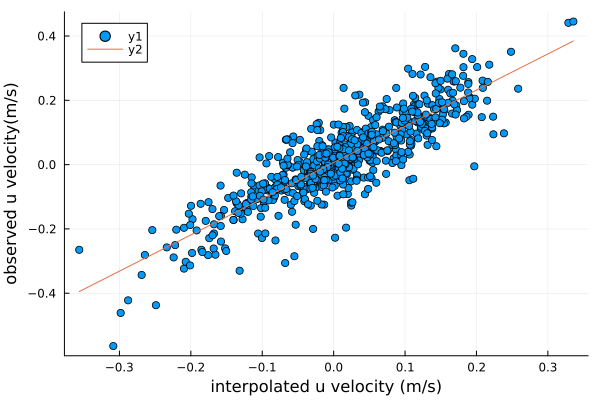

In [24]:
Plots.scatter(ui_general, uo_general, xlabel = "interpolated u velocity (m/s)", ylabel ="observed u velocity(m/s)"
    #, xlims = (0,0.5), ylims = (0,0.5)
)
plot!(ui_general, predict(ols1))

### V velocity

In [25]:
# Using GLM for linear regression

t2 = Table(vi_general=vi_general,vo_general=vo_general)

ols2 = lm(@formula(vo_general ~ vi_general), t2)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

vo_general ~ 1 + vi_general

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)   Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.005442  0.00237801  -2.29    0.0224  -0.0101114  -0.000772622
vi_general    1.24675   0.0266249   46.83    <1e-99   1.19447     1.29903
─────────────────────────────────────────────────────────────────────────────

In [26]:
r_squared_v = r2(ols2) 

0.7686425314455009

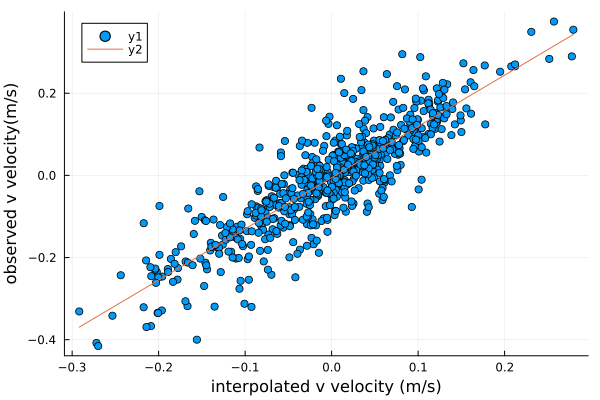

In [27]:
Plots.scatter(vi_general, vo_general, xlabel = "interpolated v velocity (m/s)", ylabel ="observed v velocity(m/s)",  
    #xlims = (0,0.5), ylims = (0,0.5)
    )
plot!(vi_general, predict(ols2))

## Scatter for variance comparison between observed and predicted
### We expect higher variance for the in-situ observations

In [28]:
# Variance computation

var_ui = sum((ui_general .- mean(ui_general)).^2) / (length(ui_general) - 1);
var_uo = sum((uo_general .- mean(uo_general)).^2) / (length(uo_general) - 1);

var_vi = sum((vi_general .- mean(vi_general)).^2) / (length(vi_general) - 1);
var_vo = sum((vo_general .- mean(vo_general)).^2) / (length(vo_general) - 1);

In [29]:
# Variance of observation vs interpoltation

println(var_ui)
println(var_uo)
println(var_vi)
println(var_vo)

# Like expected, higher variation of the dataset for observation, as soon as interpolation come from averaged dataset

0.01023048316851464
0.01735033576789965
0.007983108394614519
0.016143945170063335


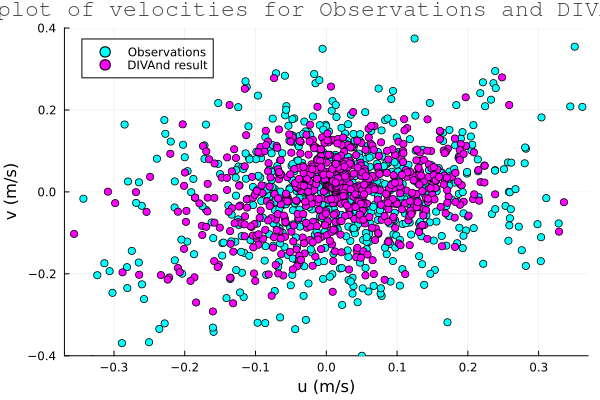

GKS: could not find font Times New Roman.ttf


In [30]:
Plots.scatter(uo_general,vo_general,color = :cyan, xlabel = "u (m/s)", ylabel = "v (m/s)", xlims = (-0.4,0.4), ylims = (-0.4,0.4),label = "Observations", title = "Scatterplot of velocities for Observations and DIVAnd Results",titlefont = font(12, "Times New Roman"))
Plots.scatter!(ui_general,vi_general,color = :magenta, xlabel = "u (m/s)", ylabel = "v (m/s)", xlims = (-0.37,0.37),label = "DIVAnd result")

## Cross validation per month

In [31]:
month = 12;

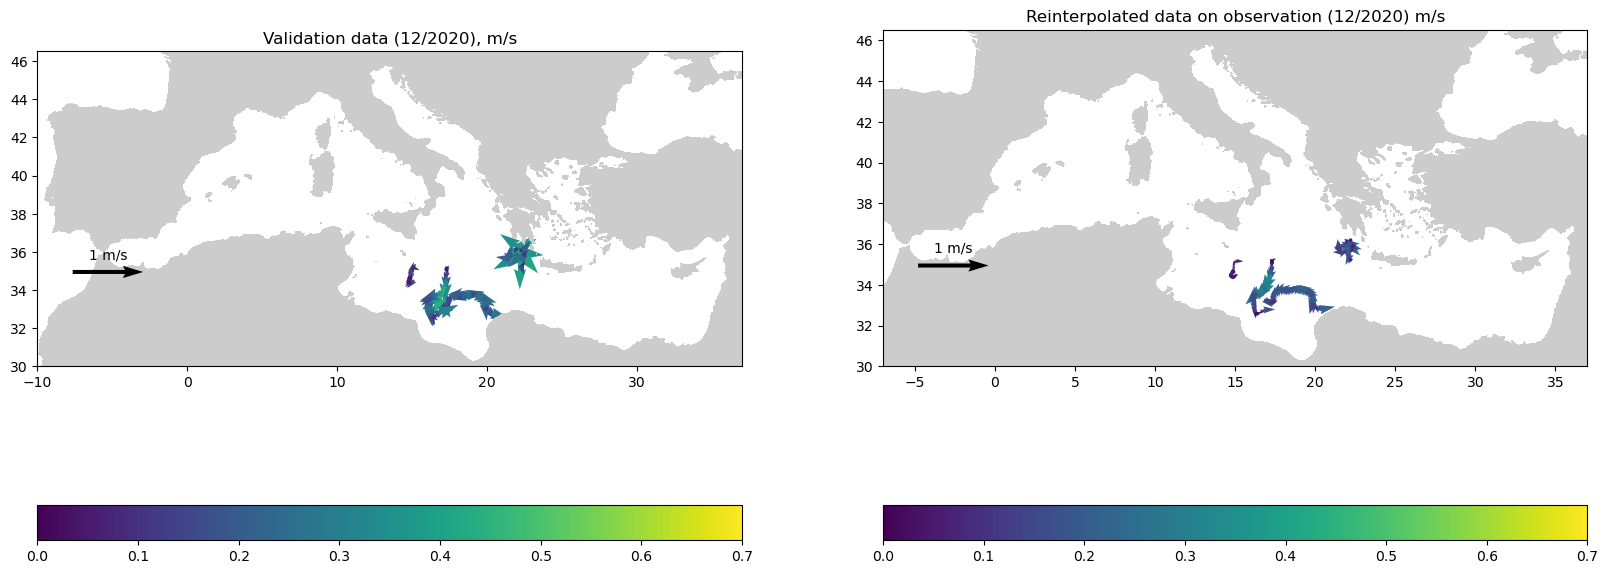

In [32]:
# Double figure
fig, (ax1, ax2) = subplots(1, 2, figsize=(20, 12))  # Ajuster la taille de la figure ici


# Random Drifters subset
subplot(1, 2, 1)

#clf(); 
q=PyPlot.quiver(xo1_[month],yo1_[month],udov1_[month],vdov1_[month],speedo[month],scale=10) #scala parameter to change (length of the arrows)

quiverkey(q,0.1,0.3,1,"1 m/s")
xlim(-10,37)
ylim(30.,46.5)
clim(0,0.7)
#colorbar(orientation="vertical")
colorbar(orientation="horizontal")
title("Validation data ($month/$year), m/s")
#CoastalCurrents.Plotting.set_aspect_ratio()
#OceanPlot.plot_coastline()
CoastalCurrents.Plotting.plotmap(bathname)
 
#fig_obs = joinpath(save_validation, "Drift_Obs_($month/$year).png")
#PyPlot.savefig(fig_obs)



# Interpolated Data
subplot(1, 2, 2)

#clf(); 
q=PyPlot.quiver(xval[month],yval[month],reinterpole_uri[month],reinterpole_vri[month],speedi_[month],scale=10) #scala parameter to change (length of the arrows)
quiverkey(q,0.1,0.3,1,"1 m/s")
xlim(-7,37)
ylim(30.,46.5)
#colorbar(orientation="vertical", shrink=0.3)
colorbar(orientation="horizontal")
clim(0,0.7)
title("Reinterpolated data on observation ($month/$year) m/s")
#CoastalCurrents.Plotting.set_aspect_ratio()
#OceanPlot.plot_coastline()
CoastalCurrents.Plotting.plotmap(bathname)

#PyPlot.savefig(joinpath(save_validation, "results_sur_observations_March19.png"))

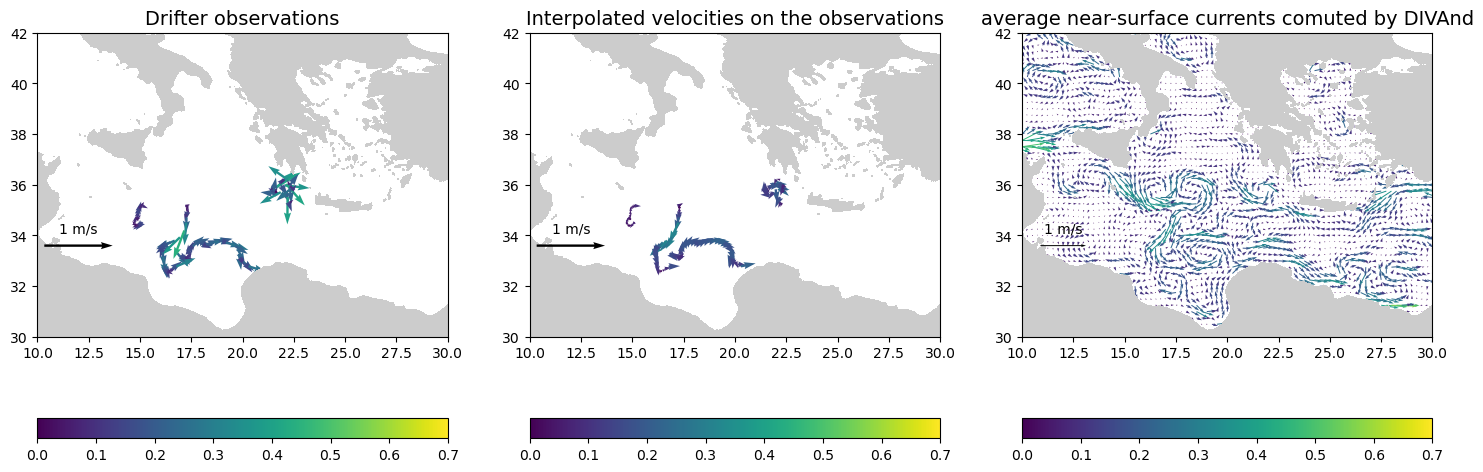

In [33]:
# Double figure
fig = figure(figsize=(18, 7))  # Taille de la figure


#SUBSET RANDOM DE DRIFTER
subplot(1, 3, 1)

#clf(); 
q=PyPlot.quiver(xo1_[month],yo1_[month],udov1_[month],vdov1_[month],speedo[month],scale=6) #scala parameter to change (length of the arrows)

quiverkey(q,0.1,0.3,1,"1 m/s")
xlim(10,30)
ylim(30,42)
clim(0,0.7)
#colorbar(orientation="vertical")
colorbar(orientation="horizontal")
title("Drifter observations", fontsize=14)
#CoastalCurrents.Plotting.set_aspect_ratio()
#OceanPlot.plot_coastline()
CoastalCurrents.Plotting.plotmap(bathname)
 
#fig_obs = joinpath(save_validation, "Drift_Obs_($month/$year).png")
#PyPlot.savefig(fig_obs)



#DONNEES INTERPOLEES
subplot(1, 3, 2)

#clf(); 
q=PyPlot.quiver(xval[month],yval[month],reinterpole_uri[month],reinterpole_vri[month],speedi_[month],scale=6) #scala parameter to change (length of the arrows)
quiverkey(q,0.1,0.3,1,"1 m/s")
xlim(10,30)
ylim(30,42)
#colorbar(orientation="vertical", shrink=0.3)
colorbar(orientation="horizontal")
clim(0,0.7)
title("Interpolated velocities on the observations", fontsize=14)
#CoastalCurrents.Plotting.set_aspect_ratio()
#OceanPlot.plot_coastline()
CoastalCurrents.Plotting.plotmap(bathname)

#PyPlot.savefig(joinpath(save_validation, "results_sur_observations_March19.png"))

#résultat de l'interpolation
subplot(1, 3, 3)

speedi = sqrt.(uri[:,:,month].^2 + vri[:,:,month].^2)

#clf(); 
q=PyPlot.quiver(xi,yi,uri[:,:,month],vri[:,:,month],speedi,scale=9) #scala parameter to change (length of the arrows)
quiverkey(q,0.1,0.3,1,"1 m/s")
xlim(10,30)
ylim(30,42)
clim(0,0.7)
#colorbar(orientation="vertical")
colorbar(orientation="horizontal")
title("average near-surface currents comuted by DIVAnd", fontsize=14)
#CoastalCurrents.Plotting.set_aspect_ratio()
#OceanPlot.plot_coastline()
CoastalCurrents.Plotting.plotmap(bathname)
#savefig(expanduser("~/Figures/bluecloud-drifter-vel-div-$(eps2_div_constraint).png"))
#savefig("DEC_ALTDRIFT_2020.jpg")


#PyPlot.savefig(joinpath(save_results, "DIVA_result_($month/$year).png"))

In [34]:
#vitesse en donnée interpolée

nanmean(abs.(speedi_[month]))

#on enleve les NaN

indices_nan = isnan.(speedi_[month]);

vecteur_sans_nani = speedi_[month][.!indices_nan];

#vitesse en donnée observée

mean(abs.(speedo[month]))

vecteur_sans_nano = speedo[month][.!indices_nan];

#corrélation entre les deux vecteurs de vitesse

cor(vecteur_sans_nano,vecteur_sans_nani)

0.7076281340920131

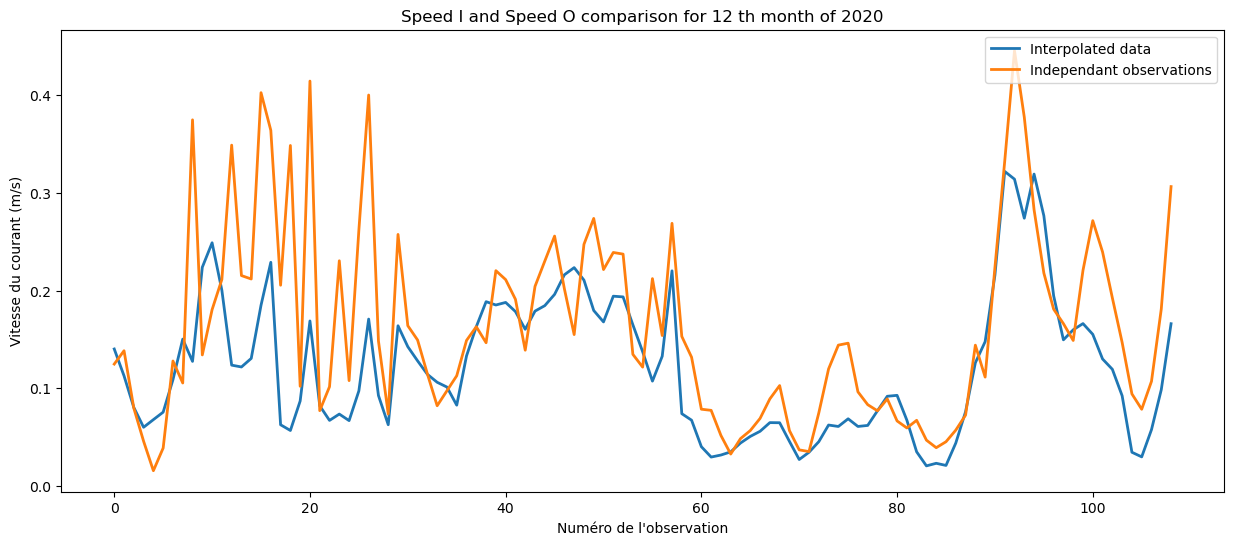

PyObject <matplotlib.legend.Legend object at 0x7fdff2f07d90>

In [35]:
fig, ax = subplots(figsize=(15, 6))  # Largeur x Hauteur


PyPlot.plot(vecteur_sans_nani, label="Interpolated data", linewidth=2)
PyPlot.plot(vecteur_sans_nano, label="Independant observations", linewidth=2)
xlabel("Numéro de l'observation")
ylabel("Vitesse du courant (m/s)")
title("Speed I and Speed O comparison for $month th month of $year")
legend(loc="upper right")

# Main Results

### General map

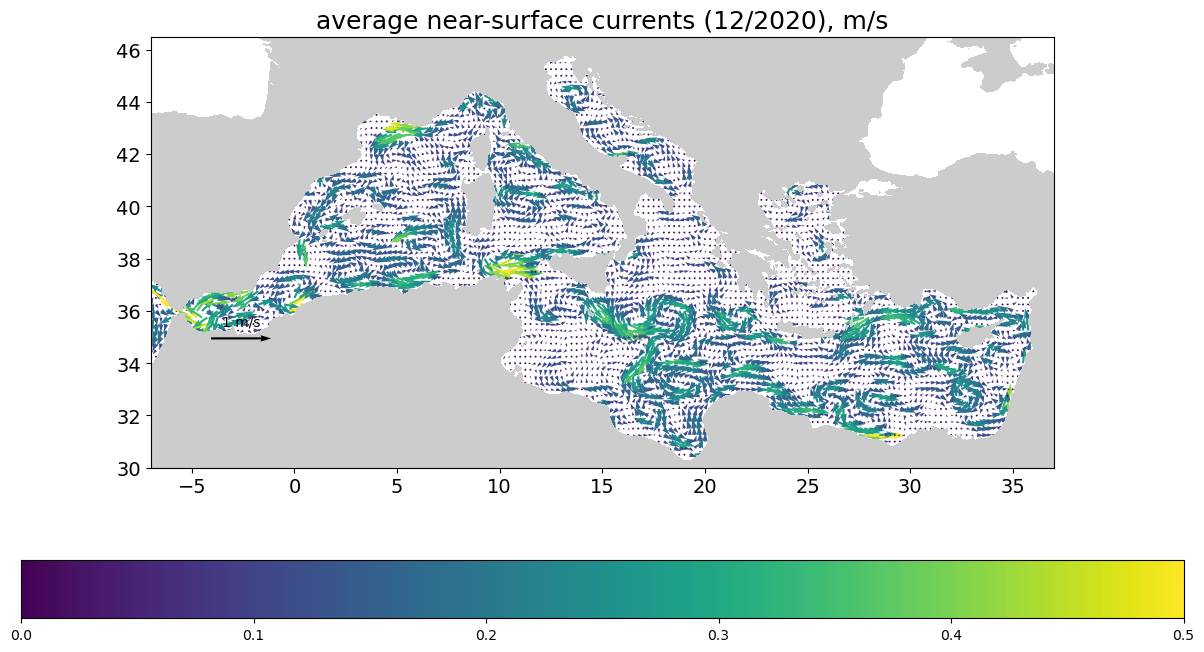

In [36]:
PyPlot.figure(figsize=(15, 8))


speedi = sqrt.(uri[:,:,month].^2 + vri[:,:,month].^2)

clf(); q=PyPlot.quiver(xi,yi,uri[:,:,month],vri[:,:,month],speedi,scale=15) #scala parameter to change (length of the arrows)
quiverkey(q,0.1,0.3,1,"1 m/s")
xlim(-7,37)
ylim(30.,46.5)
clim(0,0.5)
#colorbar(orientation="vertical")
colorbar(orientation="horizontal")
title("average near-surface currents ($month/$year), m/s", fontsize=18)
PyPlot.xticks(fontsize=14)
PyPlot.yticks(fontsize=14)
#CoastalCurrents.Plotting.set_aspect_ratio()
#OceanPlot.plot_coastline()
CoastalCurrents.Plotting.plotmap(bathname)
#savefig(expanduser("~/Figures/bluecloud-drifter-vel-div-$(eps2_div_constraint).png"))
#savefig("DEC_ALTDRIFT_2020.jpg")


#PyPlot.savefig(joinpath(save_results, "DIVA_result_($month/$year).png"))

### Regional map

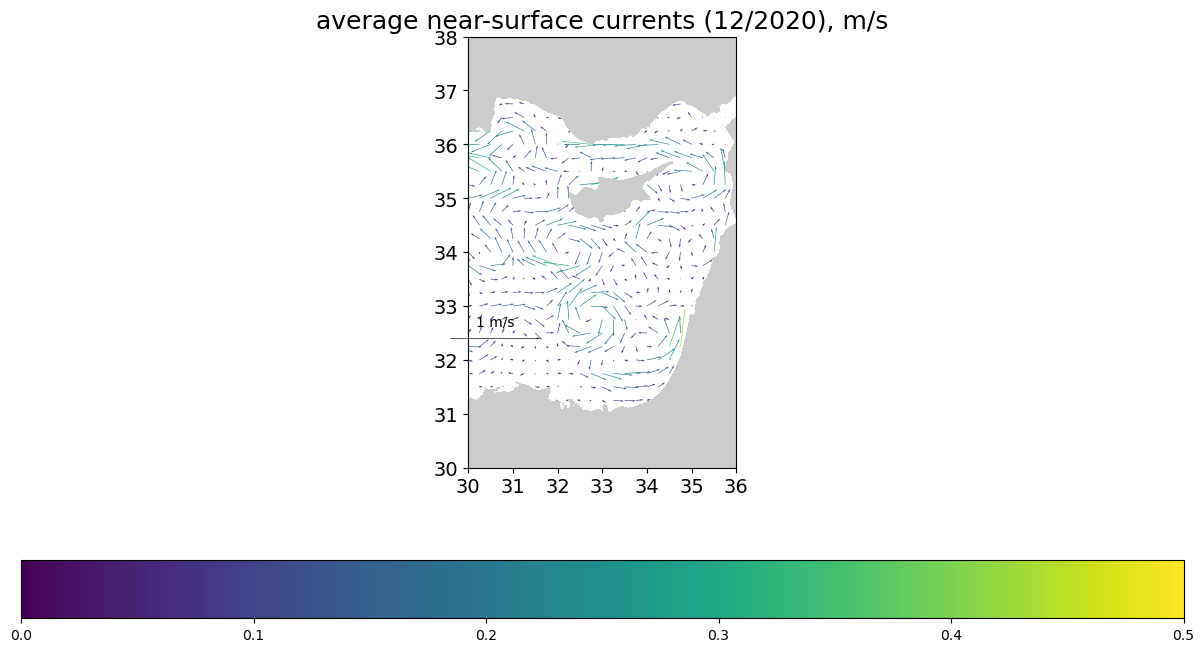

In [37]:
############ General plot ##############

PyPlot.figure(figsize=(15, 8))


speedi = sqrt.(uri[:,:,month].^2 + vri[:,:,month].^2)

clf(); q=PyPlot.quiver(xi,yi,uri[:,:,month],vri[:,:,month],speedi,scale=3) #scala parameter to change (length of the arrows)
quiverkey(q,0.1,0.3,1,"1 m/s")
xlim(30,36)
ylim(30.,38)
clim(0,0.5)
#colorbar(orientation="vertical")
colorbar(orientation="horizontal")
title("average near-surface currents ($month/$year), m/s", fontsize=18)
PyPlot.xticks(fontsize=14)
PyPlot.yticks(fontsize=14)
#CoastalCurrents.Plotting.set_aspect_ratio()
#OceanPlot.plot_coastline()
CoastalCurrents.Plotting.plotmap(bathname)
#savefig(expanduser("~/Figures/bluecloud-drifter-vel-div-$(eps2_div_constraint).png"))
#savefig("DEC_ALTDRIFT_2020.jpg")


#PyPlot.savefig(joinpath(save_results, "DIVA_result_($month/$year).png"))

# Physical analysis of the results

#### Computation of the physical variables

In [38]:
# Define the vector
uri_ = zeros(Float64, 177, 65, 12);
vri_ = zeros(Float64, 177, 65, 12);

TKEi = zeros(Float64, 177, 65, 12);
EKEi = zeros(Float64, 177, 65, 12);
uai = zeros(Float64, 177, 65, 12);
vai = zeros(Float64, 177, 65, 12); 
MKEi = zeros(Float64, 177, 65);

## Total Kinetic Energy
#### Show strong currents without paying attention to their direction

In [39]:
# Compute the total kinetic energy
TKEi = 0.5*(uri[:,:,:].^2 .+ vri[:,:,:].^2);

# Extrema of the TKE
maximum(TKEi[isfinite.(TKEi)])

1.9118614243916383

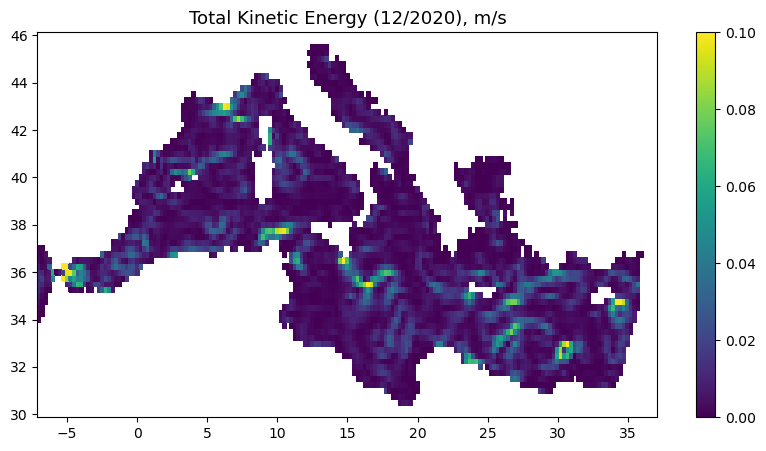

PyObject Text(0.5, 1.0, 'Total Kinetic Energy (12/2020), m/s')

In [40]:
fig = figure(figsize=(10, 5))
pcolor(xi,yi,TKEi[:,:,10])
colorbar()
clim(0,0.10)
title("Total Kinetic Energy ($month/$year), m/s", fontsize=13)

## Mean Kinetic Energy

#### Allow to see persistent currents and their direction

In [41]:
# Compute mean on time
#uri_mean = dropdims(mean(uri, dims=3), dims=3);
#vri_mean = dropdims(mean(vri, dims=3), dims=3);

In [42]:
# Compute mean on time
uri_mean = mean(uri, dims=3);
vri_mean = mean(vri, dims=3);

In [43]:
# Compute Mean Kinetic Energy
MKEi = 0.5*(uri_mean.^2 + vri_mean.^2); # check formula !!!!!!!!!!!!!!!!!!

# Extrema of the MKE
extrema(MKEi[isfinite.(MKEi)])

(1.2070150482570499e-8, 0.4109956553005096)

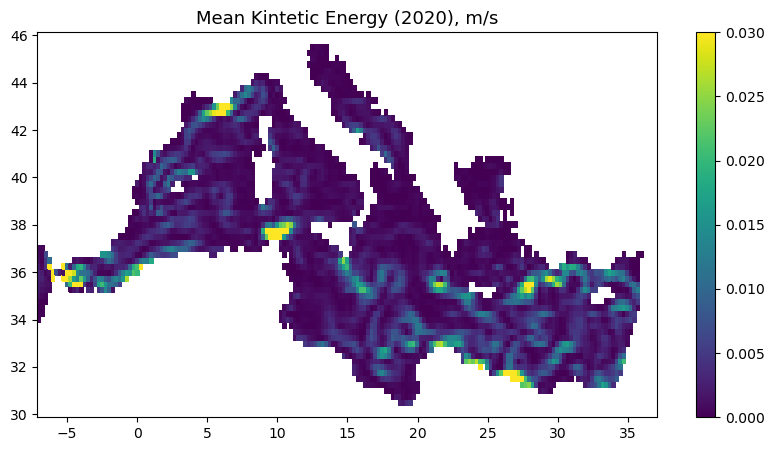

PyObject Text(0.5, 1.0, 'Mean Kintetic Energy (2020), m/s')

In [44]:
fig = figure(figsize=(10, 5))
pcolor(xi,yi,MKEi[:,:])
colorbar()
clim(0,0.03)
title("Mean Kintetic Energy ($year), m/s", fontsize=13)

## Eddy Kinetic Energy
#### Allow to see strong eddy driven regions

In [45]:
# Compute anomalies 
#for i in 1:12
#uai[:,:,i] .= uri[:,:,i] .- uri_mean[:,:]
#vai[:,:,i] .= vri[:,:,i] .- vri_mean[:,:]
#end

In [46]:
# Compute the anomalies
uai = uri .- uri_mean
vai = vri .- vri_mean

size(uai)
size(vai)

(177, 65, 12)

In [47]:
EKEi = 0.5*(uai.^2 .+ vai.^2);

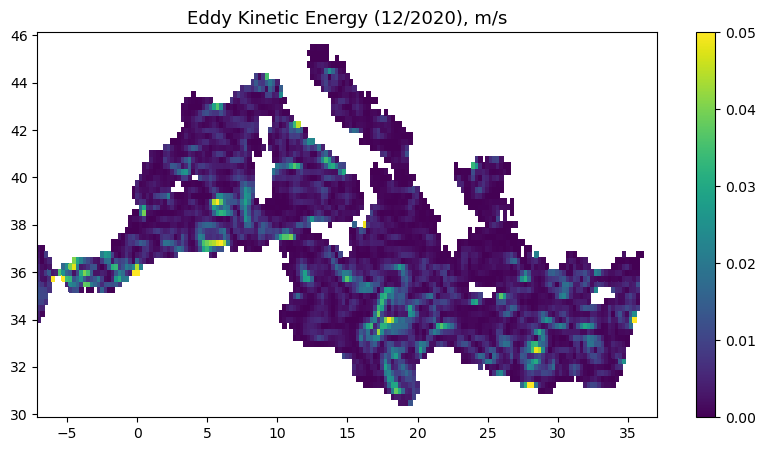

PyObject Text(0.5, 1.0, 'Eddy Kinetic Energy (12/2020), m/s')

In [48]:
fig = figure(figsize=(10, 5))
pcolor(xi,yi,EKEi[:,:,month])
colorbar()
clim(0,0.05)
title("Eddy Kinetic Energy ($month/$year), m/s", fontsize=13)

# 

# Output Data file

In [49]:
dataCMCC = NCDataset("dataCMCC.nc", "c")

Dataset: dataCMCC.nc
Group: /



In [103]:
defDim(dataCMCC, "longitude", length(yi[1,:]))
defDim(dataCMCC, "latitude", length(xi[:,1]))
defDim(dataCMCC, "time", length(uri[1,1,:]))

In [104]:
dataCMCC

Dataset: dataCMCC.nc
Group: /

Dimensions
   longitude = 65
   latitude = 177
   time = 12



In [105]:
nclon = defVar(dataCMCC, "longitude", Float64, ("longitude",))
    nclon.attrib["units"] = "degrees_east"
    nclon.attrib["standard_name"] = "longitude"
    nclon.attrib["long_name"] = "longitude"

"longitude"

In [106]:
nclat = defVar(dataCMCC, "latitude", Float64, ("latitude",))
    nclat.attrib["units"] = "degrees_north"
    nclat.attrib["standard_name"] = "latitude"
    nclat.attrib["long_name"] = "latitude"

"latitude"

In [107]:
uvel = defVar(dataCMCC, "u_velocity", Float64, ("latitude","longitude","time"))
    uvel.attrib["units"] = "m/s"
    uvel.attrib["standard_name"] = "eastward velocity"
    uvel.attrib["long_name"] = "zonal component of the velocity"

"zonal component of the velocity"

In [108]:
vvel = defVar(dataCMCC, "v_velocity", Float64, ("latitude","longitude","time"))
    vvel.attrib["units"] = "degrees_north"
    vvel.attrib["standard_name"] = "northward velocity"
    vvel.attrib["long_name"] = "meridional component of the velocity"

"meridional component of the velocity"

In [109]:
dataCMCC["latitude"][:] = xi[:,1];
dataCMCC["longitude"][:] = yi[1,:];

dataCMCC["u_velocity"][:,:,:] = uri;
dataCMCC["v_velocity"][:,:,:] = vri;

In [110]:
close(dataCMCC)

closed Dataset